# Optimization of Transductive Conformal Predictors using Naive Bayes Classifier via Incremental and Decremental Learning

This notebook documents our experiments and allows to reproduce. We first implement the Naive Bayes Classifiers for discrete and continuous variables, namely **MultinomialNB** and **GaussianNB**. Next, we define the nonconformity measure score and standard and optimized versions for Transductive Conformal Predictor (TCP) using the two classifiers. Finally, we evaluate the average running time of prediction and compare them.

The code in this notebook refers to some ideas from the paper **Exact Optimization of Conformal Predictors via Incremental and Decremental Learning**, and use the utility class **eli.py** directly. You can find the paper, code and utility class in the link: https://github.com/gchers/exact-cp-optimization

# Settings

## Multiprocessing Settings

In [1]:
# Disable multithreading in numpy for fair measurements.
# Needs to be run before importing numpy.
import os
import ctypes
def disable_np_multithreading():
    """A multithreading-disabling routine for numpy, taken
    from https://github.com/numpy/numpy/issues/11826.
    """
    try:
        import mkl
        mkl.set_num_threads(1)
        return 0
    except:
        pass 
    
    for name in [ "libmkl_rt.so", "libmkl_rt.dylib", "mkl_Rt.dll"]: 
        try: 
            mkl_rt = ctypes.CDLL(name)
            mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(1)))
            return 0 
        except:
            pass   

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1" 
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
disable_np_multithreading()

0

## Install Libraries

In [2]:
pip install sh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install arrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.7 MB/s eta 0:00:00


In [4]:
pip install setproctitle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install flatten-dict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install parameterized

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##  Import Libraries

In [7]:
# Import class Eli from the separate utility class file 'eli.py'.
from eli import Eli 
import copy
import math
import time
import random
import unittest
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pylab as plt
from scipy.special import softmax
from sklearn import preprocessing
import matplotlib.ticker as ticker
from sklearn.datasets import load_iris
from parameterized import parameterized
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Plots Settings

In [8]:
# Plots settings.
DPI = 300
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.style.use(['seaborn-v0_8-white', 'seaborn-v0_8-talk'])

# Methodology

## Naive Bayes Classifier

The following theoretical knowledge about **Naive Bayes Classifiers**, **MultinomialNB** and **GaussianNB** mainly refer to website https://scikit-learn.org/stable/, and the specific link is as follows: https://scikit-learn.org/stable/modules/naive_bayes.html. On this basis, some changes are made in order to be consistent with the symbol marking in the thesis. Refer to the thesis for details.

### General NBC

**Please refer to the accompanying thesis for details.**

### MultinomialNB for Discrete Variables

**Please refer to the accompanying thesis for details.**

### GaussianNB for Continuous Variables

**Please refer to the accompanying thesis for details.**

## Transductive Conformal Predictor

### Nonconformity Measure

**Please refer to the accompanying thesis for details.**


### General TCP

**Please refer to the accompanying thesis for details.**


### Standard TCP using MultinomialNB

**Please refer to the accompanying thesis for details.**

###  Standard TCP using GaussianNB

**Please refer to the accompanying thesis for details.**

### Optimized TCP using MultinomialNB via I&D Learning

**Please refer to the accompanying thesis for details.**

### Optimized TCP using GaussianNB via I&D Learning

**Please refer to the accompanying thesis for details.**

# Definitions


## Functions


### generator_mnb

In [9]:
# Define a function to generate data for MultinomialNB.
def generator_mnb(n_samples, n_features, n_classes):
  rng = np.random.RandomState(0)
  # Because the random number range doesn't matter, we set the range to 2 for simplicity.
  X = rng.randint(2, size = (n_samples, n_features))
  Y = rng.randint(n_classes, size = n_samples)
  # Chang the data type from 'int' to 'str', which is easier to do string concatenation for 
  # the key in dictionary data structure.
  X = X.astype(str)
  Y = Y.astype(str)
  return X, Y

### compute_pvalues

In [10]:
# Define a function to compute p-values for x and all candidate class labels given 
# a nonconformity measure ncm.
def compute_pvalues(x, labels, ncm):
    pvalues_x = []
    for y in labels:
        score_x, scores = ncm.compute_scores(x, y)
        pvalue = (1 + sum(scores >= score_x)) / (1 + len(scores))
        pvalues_x.append(pvalue)

    return pvalues_x

### cp_predict

In [11]:
# Define a function to return p-values and running time for x and all candidate 
# class labels given a nonconformity measure ncm.
def cp_predict(Xtrain, Ytrain, Xtest, labels, ncm, return_time=False, timeout=None):
    
    # Record training time.
    start = time.perf_counter()
    ncm.train(Xtrain, Ytrain)
    train_time = time.perf_counter() - start

    # Record p-values and cumulative prediction time for each x in Xtest.
    start = time.perf_counter()
    prediction_times = []
    reached_timeout = False
    pvalues = []
    for x in Xtest:
        pvalues_x = compute_pvalues(x, labels, ncm)
        pvalues.append(pvalues_x)
        
        # Store prediction time.
        t = time.perf_counter() - start
        prediction_times.append(t)
        
        # Check if reached timeout.
        if timeout and t > timeout:
            reached_timeout = True
            break
    
    if return_time:
        return np.array(pvalues), {"training_time": train_time,
                                   "prediction_time": prediction_times,
                                   "reached_timeout": reached_timeout,
                                   }
    else:
        return np.array(pvalues)

### evaluate_ncm

In [12]:
# Define a function to evaluate running time for ncm.
def evaluate_ncm(ncm, train_size, max_test_size, n_classes, n_dimensions, timeout, is_mnb):
    
    # Parses the ncm expression and produce the ncm class instance.
    ncm_class = eval(ncm)
    ncm = ncm_class()
    
    # Judge to generate discrete or continuous data set.
    if is_mnb:
      # Use our custom function 'generator_mnb'
      X, Y = generator_mnb(n_samples = train_size+max_test_size,
                           n_features = n_dimensions, 
                           n_classes=n_classes)
    else:
      # Use random generation function 'make_classification' from sklearn
      X, Y = make_classification(n_samples = train_size+max_test_size,
                                 n_features = n_dimensions, 
                                 n_classes = n_classes)
    
    # Split the dataset into training and test sets, and all the objects in the 
    # test set are going to do prediction.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=max_test_size)
    _, times = cp_predict(Xtrain, Ytrain, Xtest, np.unique(Y), ncm, return_time=True, timeout=timeout)
    
    # Return the times
    return times

## Classes


### NCM

In [13]:
# Define a class for nonconformity measures.
class NCM:

  def name(self):
    return self.__class__.__name__

  # By default, this simply stores the training data as an element of the NCM object.
  def train(self, X, Y):
      self.X = np.array(X)
      self.Y = np.array(Y)

  # Should return the nonconformity scorer for the training data (X, Y), which is a 
  # function (x, y) -> score
  def train_ncm(self, X, Y):
      def example_scorer(x, y):
          raise NotImplemented
      
      return example_scorer

  # Returns a tuple: (score_x, scores) where score_x is the score for (x, y) and
  # scores are the nonconformity scores for the training examples. 
  def compute_scores(self, x, y, only_score_x = False):
    ncm = self.train_ncm(self.X, self.Y)
    score_x = ncm(x, y)
    
    # If `only_score_x = True`, this method returns only the prediction for (x, y), `score_x`.
    if only_score_x:
        return score_x
    
    scores = []
    
    for i in range(len(self.X)):

        # Score the i-th example, removing it from the training data set and appending (x, y) instead.
        idx = np.array(list(range(len(self.X))))
        ncm = self.train_ncm(np.row_stack((self.X[idx!=i,:], x)),np.append(self.Y[idx!=i], y))
        scores.append(ncm(self.X[i,:], self.Y[i]))
        
    return score_x, scores

### MultinomialNB

In [14]:
# Define a class to implement Naive Bayes Classifier for discrete variables.
class MultinomialNB:

  def __init__(self): 
    self.X = pd.DataFrame
    self.Y = pd.Series
    self.train_size = int
    self.feature_num = int
    self.features = list
    self.classes = list
    self.class_count = {}
    self.value_count = {}

  # Define a function to store the class counts in the dictionary 'self.class_count'.
  def _calc_class_count(self):
    # Because 'class' is an keyword identifier in python, we have to add an underline before.
    for _class in self.classes:
      _class_count = sum(self.Y == _class)
      self.class_count[_class] = _class_count

  # Define a function to store the feature value counts by classes, features 
  # and feature values in the dictionary 'self.value_count'.
  def _calc_value_count(self):
    for feature in self.features:

      for _class in self.classes:
        _class_count = sum(self.Y == _class)
        value_count = self.X[feature][self.Y[self.Y == _class].index.values.tolist()].value_counts().to_dict()     
        
        for value, count in value_count.items():
          self.value_count[feature][value + '_' + _class] = count
  
  # Define a function to fit the MultinomialNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_count'.
  def fit(self, X, Y):
    self.X = pd.DataFrame(X)
    self.Y = pd.Series(Y)
    self.train_size = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.features = list(self.X.columns)
    self.classes = list(np.unique(self.Y))
    
    # Initialize the dictionaries 'self.class_count' and 'self.value_count' 
    # and set the default value to be 0
    for feature in self.features:
      self.value_count[feature] = {}

      for value in np.unique(self.X[feature]):
        for _class in self.classes:
          self.value_count[feature].update({value+'_'+_class:0})
          self.class_count.update({_class: 0})

    self._calc_class_count()
    self._calc_value_count()
  
  # Define a function to calculate posterior probability for the data instance x.
  def predict_proba(self, x):
    probs_outcome = []
    x = np.array(x)

    for _class in self.classes:

      # Calculate the prior class probability 'prior'.
      prior = self.class_count[_class] / self.train_size
      likelihood = 1

      # Calculate the likelihood of each feature and multiply them together.
      for feature, x_feature_value in zip(self.features, x):
        likelihood *= self.value_count[feature][x_feature_value + '_' + _class] / self.class_count[_class]
      
      # Calculate the final posterior probability for x.
      posterior = (likelihood * prior)
      probs_outcome.append(posterior)
    
    # Use the 'softmax' function to make the probability sum be one.
    return softmax(probs_outcome)

### Standard TCP using MultinomialNB (STCPM)

In [15]:
# Define a class to implement Standard Transductive Conformal Predictor using MultinomialNB.
class STCPM(NCM):
  def train_ncm(self, X, Y):
      mnb = MultinomialNB()
      mnb.fit(X, Y)

      def scorer(x, y):
        y = np.array([y],dtype = int)
        
        # Return the nonconformity score for a data instance x with class y.
        return -mnb.predict_proba(x)[y][0]
      
      # Return the scorer to score any test data instance.
      return scorer

### Optimized TCP using MultinomialNB (OTCPM)

In [16]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# But we overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPM(NCM):
  
  def __init__(self):
    self.X = pd.DataFrame
    self.Y = pd.Series
    self.train_size = int
    self.feature_num = int
    self.features = list
    self.classes = list
    self.class_count = {}
    self.value_count = {}

  # Define a function to store the class counts in the dictionary 'self.class_count'. 
  def _calc_class_count(self): 
    for _class in self.classes:
      _class_count = sum(self.Y == _class)
      self.class_count[_class] = _class_count
  
  # Define a function to store the feature value counts by classes, features 
  # and feature values in the dictionary 'self.value_count'.
  def _calc_value_count(self): 
    for feature in self.features:
      for _class in self.classes:
        _class_count = sum(self.Y == _class)
        value_count = self.X[feature][self.Y[self.Y == _class].index.values.tolist()].value_counts().to_dict()
        
        for value, count in value_count.items():
          self.value_count[feature][value + '_' + _class] = count
  
  # Define a function to fit the MultinomialNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_count'. 
  def train(self, X, Y):
    self.X = pd.DataFrame(X)
    self.Y = pd.Series(Y)
    self.train_size = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.features = list(self.X.columns)
    self.classes = list(np.unique(self.Y))
      
    for feature in self.features:
      self.value_count[feature] = {}
      
      for value in np.unique(self.X[feature]):        
        for _class in self.classes:
          self.value_count[feature].update({value+'_'+_class:0})
          self.class_count.update({_class: 0})
    
    self._calc_class_count()
    self._calc_value_count()
    
  def compute_scores(self, x, y, only_score_x=False):
    
    # Copy the result 'sef.class_count' and 'self.value_count' from the first fit
    # and store them into 'class_count' and 'value_count'.
    class_count = copy.deepcopy(self.class_count)
    value_count = copy.deepcopy(self.value_count)

    probs_outcome = []

    for _class in self.classes:
      # Calculate the prior class probability 'prior'.
      prior = class_count[_class] / self.train_size
      likelihood = 1
      
      # Calculate the likelihood of each feature and multiply them together.
      for feature, x_feature_value in zip(self.features, x):
          likelihood *= value_count[feature][x_feature_value + '_' + _class] / class_count[_class]
      
      # Calculate the final posterior probability for x.
      posterior = (likelihood * prior)
      probs_outcome.append(posterior)
    
    # Use the 'softmax' function to make the probability sum be one.
    result = softmax(probs_outcome)
    
    score_x = -result[np.array(y, dtype = int)]
    
    # If `only_score_x = True`, this method returns only the prediction for (x, y).
    if only_score_x:
      return score_x
      
    scores = []

    # Instead of training a totally new MultinomialNB classifier for each instance in the training 
    # data set , we just modify the two dictionaries 'class_count' and 'value_count' by comparing 
    # the feature values of the adding instance with the removing instance.
    for i in range(len(self.X)):
      x_out = self.X.iloc[i,:]
      y_out = self.Y.iloc[i]

      # If new object and old object don't have the same class.
      if y != y_out:
        class_count[y] += 1
        class_count[y_out] -= 1
        for feature in self.features:
          # For a feature, if new object and old object have the same value.
          if x[feature] == x_out[feature]:
            value_count[feature][x[feature] + '_' + y] += 1
            value_count[feature][x[feature] + '_' + y_out] -= 1
          # For a feature, if new object and old object don't have the same value.
          else:
            value_count[feature][x[feature] + '_' + y] += 1
            value_count[feature][x_out[feature] + '_' + y_out] -= 1
      
      # If new object and old object have the same class.
      else:
        for feature in self.features:
          # For a feature, if new object and old object don't have the same value.
          if x[feature] != x_out[feature]:
            value_count[feature][x[feature] + '_' + y] += 1
            value_count[feature][x_out[feature] + '_' + y] -= 1
      
      # Using the updated 'class_count' and 'value_count' to output the prediction
      # probability and nonconformity score.
      probs_outcome = []
      
      for _class in self.classes:
        prior = class_count[_class] / self.train_size
        likelihood = 1
        
        for feature, x_out_feature_value in zip(self.features, x_out):
            likelihood *= value_count[feature][x_out_feature_value + '_' + _class] / class_count[_class]

        posterior = (likelihood * prior)
        probs_outcome.append(posterior)

      result = softmax(probs_outcome)
      score = -result[np.array(y_out, dtype = int)]
      scores.append(score)
      
      # Assign (x_out, y_out) to (x, y), and continue to the next iteration.
      x = x_out
      y = y_out

    return score_x, scores

### GaussianNB


In [17]:
# Define a class to implement Naive Bayes Classifier for continuous variables.
class GaussianNB:

  def __init__(self):
    self.X = pd.DataFrame
    self.Y = pd.Series
    self.train_size = int
    self.feature_num = int
    self.features = list
    self.classes = list
    self.class_count = {}
    self.value_sum = {}
  
  # Define a function to store the class counts in the dictionary 'self.class_count'.
  def _calc_class_count(self):
    for _class in self.classes:
      _class_count = sum(self.Y == _class)
      self.class_count[_class] = _class_count
  
  # Define a function to store the feature value 'sum' and 'sum_of_squares' by classes, features 
  # in the dictionary 'self.likelihoods'.
  def _calc_value_sum(self):
    for feature in self.features:
      for _class in self.classes:
        self.value_sum[feature][_class]['sum'] = self.X[feature][self.Y[self.Y == _class].index.values.tolist()].sum()
        self.value_sum[feature][_class]['sum_of_squares'] = np.sum(np.square(self.X[feature][self.Y[self.Y == _class].index.values.tolist()]))

  # Define a function to fit the GaussianNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_sum'.
  def fit(self, X, Y): 
    self.X = pd.DataFrame(X)
    self.Y = pd.Series(Y)
    self.train_size = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.features = list(self.X.columns)
    self.classes = list(np.unique(self.Y))
   
    # Initialize the dictionaries 'self.class_count' and 'self.value_sum' 
    # and set the default value to be 0
    for feature in self.features:
      self.value_sum[feature] = {}

      for _class in self.classes:
        self.value_sum[feature].update({_class:{}})
        self.class_count.update({_class: 0})

    self._calc_class_count()
    self._calc_value_sum()

  # Define a function to calculates posterior probability for a data object x.
  def predict_proba(self, x):
    probs_outcome = []
    x = np.array(x)

    for _class in self.classes:

      # Calculate the prior class probability 'prior'.
      prior = self.class_count[_class] / self.train_size
      likelihood = 1

      # Calculate the likelihood of each feature and multiply them together.
      for feature, x_feature_value in zip(self.features, x):
        sum = self.value_sum[feature][_class]['sum']
        sum_of_squares = self.value_sum[feature][_class]['sum_of_squares']
        mean = sum / self.class_count[_class]
        var = sum_of_squares / self.class_count[_class] - mean**2
        likelihood *= (1/math.sqrt(2*math.pi*var)) * np.exp(-(x_feature_value - mean)**2 / (2*var))
      
      # Calculate the final posterior probability for x.
      posterior = (likelihood * prior)
      probs_outcome.append(posterior)
    
    # Use the 'softmax' function to make the probability sum be one.
    return softmax(probs_outcome)

### Standard TCP using GaussianNB (STCPG)

In [18]:
# Define a class to implement Standard Transductive Conformal Predictor using GaussianlNB.
class STCPG(NCM):

    def train_ncm(self, X, Y):
        gnb = GaussianNB()
        gnb.fit(X, Y)
         
        def scorer(x, y):
          y = np.array([y],dtype = int)
          # Return the nonconformity score for a data object x with label y.
          return -gnb.predict_proba(x)[y][0]
        
        # Return the scorer to score any test data object.
        return scorer

### Optimized TCP using GaussianNB (OTCPG)

In [19]:
# Define a class to implement Optimized Transductive Conformal Predictor using MultinomialNB.
# But we overowrite the 'compute_scores' function using incremental and decremental learning.
class OTCPG(NCM):
  
  def __init__(self):
    self.X = pd.DataFrame
    self.Y = pd.Series
    self.train_size = int
    self.feature_num = int
    self.features = list
    self.classes = list
    self.class_count = {}
    self.value_sum= {}
    
  # Define a function to store the prior class counts in the dictionary 'self.class_count'. 
  def _calc_class_count(self):
    for _class in np.unique(self.Y):
      _class_count = sum(self.Y == _class)
      self.class_count[_class] = _class_count
  
  # Define a function to store the feature value 'sum' and 'sum_of_squares' by classes, features 
  # in the dictionary 'self.value_sum'.
  def _calc_value_sum(self):
    for feature in self.features:
      for _class in self.classes:
        self.value_sum[feature][_class]['sum'] = self.X[feature][self.Y[self.Y == _class].index.values.tolist()].sum()
        self.value_sum[feature][_class]['sum_of_squares'] = np.sum(np.square(self.X[feature][self.Y[self.Y == _class].index.values.tolist()]))

  
  # Define a function to fit the GaussianNB on the training data X, Y
  # and store the result in 'self.class_count' and 'self.value_sum'.
  def train(self, X, Y):  
    self.X = pd.DataFrame(X)
    self.Y = pd.Series(Y)
    self.train_size = self.X.shape[0]
    self.feature_num = self.X.shape[1]
    self.features = list(self.X.columns)
    self.classes = list(np.unique(self.Y))

    for feature in self.features:
      self.value_sum[feature] = {}

      for _class in self.classes:
        self.value_sum[feature].update({_class:{}})
        self.class_count.update({_class: 0})

    self._calc_class_count()
    self._calc_value_sum()
    
  def compute_scores(self, x, y, only_score_x=False):
    
    # Copy the result 'sef.class_count' and 'self.value_sum' from the first fit
    # and store them into 'class_count' and 'value_sum'.
    class_count = copy.deepcopy(self.class_count)
    value_sum = copy.deepcopy(self.value_sum)

    probs_outcome = []
    x = np.array(x)

    for _class in self.classes:
      # Calculate the prior class probability 'prior'.
      prior = class_count[_class] / self.train_size
      likelihood = 1
      
      # Calculate the likelihood of each feature and multiply them together.
      for feature, x_feature_value in zip(self.features, x):
        sum = value_sum[feature][_class]['sum']
        sum_of_squares = value_sum[feature][_class]['sum_of_squares']
        mean = sum / class_count[_class]
        var = sum_of_squares / class_count[_class] - mean**2
        likelihood *= (1/math.sqrt(2*math.pi*var)) * np.exp(-(x_feature_value - mean)**2 / (2*var))
      
      # Calculate the final posterior probability for x.
      posterior = (likelihood * prior)
      probs_outcome.append(posterior)
    
    # Use the 'softmax' function to make the probability sum be one.
    result = softmax(probs_outcome)
    score_x = -result[np.array(y, dtype = int)]
    
    # If `only_score_x = True`, this method returns only the prediction for (x, y).
    if only_score_x:
      return score_x
      
    scores = []

    # Instead of training a totally new GaussianNB classifier for each instance in the training 
    # data set, we just modify the two dictionaries 'class_count' and 'value_sum' by comparing 
    # the feature values of the adding instance with the removing instance.
    for i in range(len(self.X)):
      x_out = self.X.iloc[i,:]
      y_out = self.Y.iloc[i]
      
      # If new object and old object don't have the same class.
      if y != y_out:
        for feature, x_feature_value, x_out_feature_value in zip(self.features, x, x_out):            
          value_sum[feature][y]['sum'] += x_feature_value
          value_sum[feature][y_out]['sum'] -= x_out_feature_value
          value_sum[feature][y]['sum_of_squares'] += x_feature_value**2
          value_sum[feature][y_out]['sum_of_squares'] -= x_out_feature_value**2
        class_count[y] += 1
        class_count[y_out] -= 1
      
      # If new object and old object have the same class.
      else:
        for feature, x_feature_value, x_out_feature_value in zip(self.features, x, x_out):
          value_sum[feature][y]['sum'] += (x_feature_value - x_out_feature_value)
          value_sum[feature][y]['sum_of_squares'] += (x_feature_value**2 - x_out_feature_value**2)
      
      # Using the updated 'class_count' and 'value_sum' to output the prediction
      # probability and nonconformity score.
      probs_outcome = []

      for _class in self.classes:
        prior = class_count[_class] / self.train_size
        likelihood = 1

        for feature, feature_value in zip(self.features, x_out):
          sum = value_sum[feature][_class]['sum']
          sum_of_squares = value_sum[feature][_class]['sum_of_squares']
          mean = sum / class_count[_class]
          var = sum_of_squares / class_count[_class] - mean**2
          likelihood *= (1/math.sqrt(2*math.pi*var)) * np.exp(-(feature_value - mean)**2 / (2*var))
        
        posterior = (likelihood * prior)
        probs_outcome.append(posterior)
      
      result = softmax(probs_outcome)
      score = -result[np.array(y_out, dtype = int)]
      scores.append(score)
 
      # Assign (x_out, y_out) to (x, y), and continue to the next iteration.
      x = x_out
      y = y_out

    return score_x, scores

# Correctness test

## MultinomialNB

In [20]:
# Define a class to test MultinomialNB on hand-calculated values.
# Mainly by comparing the output class prediction probabilities.
class MultinomialNB_Test(unittest.TestCase):
    
    def test_MultinomialNB(self):
      X = [["0", "0"], ["0", "1"], ["1", "0"], ["1", "1"], ["0", "1"]]
      Y = np.array(["0", "1", "1", "0", "1"])
      x = ["1", "1"]
      
      """
      According to the training dataset above, we have 5 objects with 2 classes 
      (2 objects for class "0" and 3 objects for class "1"), and 2 features. 
      For each feature, we only have 2 types of feature values, both "0" and "1". 
      We summarize the counts by classes, features and feature values in the table below.

      Class     Feature1_Value: "0"     Feature1_Value: "1"     Feature2_Value: "0"   Feature2_Value: "1"

      "0"       1                       1                       1                     1

      "1"       2                       1                       1                     2
      
      From this talbe, we can calculate the probability for the test object x.
      """ 
      
      # Probability for x to be 0
      prob_x_0 =  2/5 * 1/2 * 1/2
      # Probability for x to be 0
      prob_x_1 = 3/5 * 1/3 * 2/3
      
      expected_prob = softmax([prob_x_0, prob_x_1])
      expected_prob = list(expected_prob)
      
      # Use our custom function 'MultinomialNB' to output the probability.
      mnb = MultinomialNB()
      mnb.fit(X, Y)
      output = mnb.predict_proba(x)
      output = list(output)

      self.assertListEqual(output, expected_prob)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(MultinomialNB_Test)
_ = unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.032s

OK


## GaussianNB

In [21]:
# Define a class to test GaussianNB on hand-calculated values.
# Mainly by comparing the output class prediction probabilities.
class GaussianNB_Test(unittest.TestCase):

    def test_GaussianNB(self):
      X = [[0.0, 0.1], [0.2, 0.3], [0.4, 0.5], [0.6, 0.7], [0.8, 0.9]]
      Y = np.array([0, 1, 1, 0, 1])
      x = [1.0, 1.0]

      X = pd.DataFrame(X)
      Y = pd.Series(Y)

      # Get the class counts.
      count_c0 = Y[Y==0].count()
      count_c1 = Y[Y==1].count()

      # Get the mean and var by classes and features.      
      mean_c0_f0 = X.iloc[Y[Y==0].index,0].mean()
      mean_c0_f1 = X.iloc[Y[Y==0].index,1].mean()
      mean_c1_f0 = X.iloc[Y[Y==1].index,0].mean()
      mean_c1_f1 = X.iloc[Y[Y==1].index,1].mean()
      var_c0_f0 = X.iloc[Y[Y==0].index,0].var(ddof = 0)
      var_c0_f1 = X.iloc[Y[Y==0].index,1].var(ddof = 0)
      var_c1_f0 = X.iloc[Y[Y==1].index,0].var(ddof = 0)
      var_c1_f1 = X.iloc[Y[Y==1].index,1].var(ddof = 0)

      # Probability for x to be 0
      prob_x_0 = count_c0 / 5 * (1/math.sqrt(2*math.pi*var_c0_f0)) * np.exp(-(x[0] - mean_c0_f0)**2 / (2*var_c0_f0)) \
                              * (1/math.sqrt(2*math.pi*var_c0_f1)) * np.exp(-(x[1] - mean_c0_f1)**2 / (2*var_c0_f1))

      # Probability for x to be 1
      prob_x_1 = count_c1 / 5 * (1/math.sqrt(2*math.pi*var_c1_f0)) * np.exp(-(x[0] - mean_c1_f0)**2 / (2*var_c1_f0)) \
                              * (1/math.sqrt(2*math.pi*var_c1_f1)) * np.exp(-(x[1] - mean_c1_f1)**2 / (2*var_c1_f1))
            
      expected_prob = softmax([prob_x_0, prob_x_1])
      
      # Use our custom function 'MultinomialNB' to output the probability.
      gnb = GaussianNB()
      gnb.fit(X, Y)
      output = gnb.predict_proba(x)
      # Because the precision of the decimal point is different, we're just going to go to 
      # 7 decimal places to see if it's equal.
      np.testing.assert_allclose(output, expected_prob, rtol=1e-7)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(GaussianNB_Test)
_ = unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.020s

OK


# Consistency test

## STCPM vs OTCPM


Testing: STCPM, OTCPM
p-value: 0.33 0.33


.
----------------------------------------------------------------------
Ran 1 test in 1.850s

OK


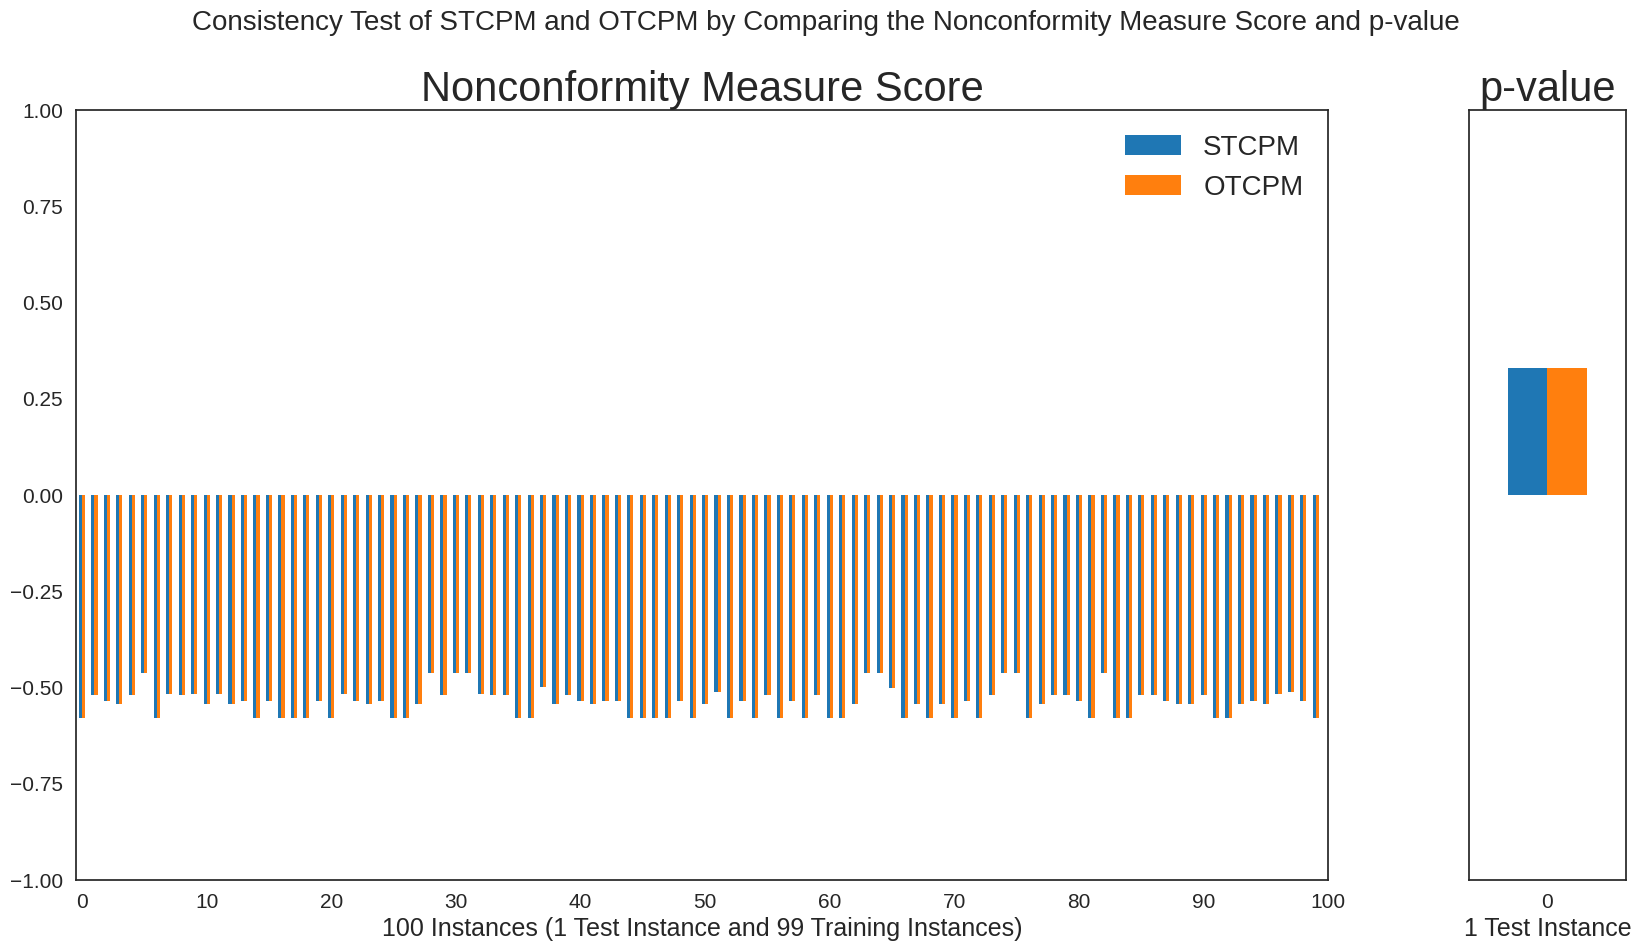

In [22]:
# Define a class to verify that STCPM is equivalent to OTCPM.
# Mainly by comparing nonconformity measure scores.
class STCPM_vs_OTCPM_Test(unittest.TestCase):
    
    def setUp(self):       
        X, Y = load_iris(return_X_y=True)
        # Convert feature value into 0 or 1 by using MinMaxScaler() and round() functions.
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        X = np.round(X).astype(int)
        # Only consider 2 classes (the first 100 instances, 50 for each class) for simplicity.
        X = X[0:100]
        Y = Y[0:100]
        X = X.astype(str)
        Y = Y.astype(str)
        
        np.random.seed(2)
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=1, random_state=0)
    
    @parameterized.expand([
        [STCPM(), OTCPM()]])
    
    def test_equivalent(self, ncm_a, ncm_b, rtol=1e-07):
        print(f"Testing: {ncm_a.__class__.__name__}, {ncm_b.__class__.__name__}")
        ncm_a.train(self.Xtrain, self.Ytrain)
        ncm_b.train(self.Xtrain, self.Ytrain)
        
        for x, y in zip(self.Xtest, self.Ytest):
            score_x_a, scores_a = ncm_a.compute_scores(x, y)
            score_x_b, scores_b = ncm_b.compute_scores(x, y)
            pvalue_a = (1 + sum(score_x_a >= scores_a)) / (1 + len(scores_a))
            pvalue_b = (1 + sum(score_x_b >= scores_b)) / (1 + len(scores_b))
            np.testing.assert_allclose(score_x_a, score_x_b, rtol=rtol)
            np.testing.assert_allclose(scores_a, scores_b, rtol=rtol)
            np.testing.assert_allclose(pvalue_a, pvalue_b, rtol=rtol)

            print("p-value:", pvalue_a, pvalue_b)

            # Collect 100 nonconformity measure socres.
            scores_a.insert(0,score_x_a)
            scores_b.insert(0,score_x_b)

            score = pd.DataFrame(
                {'Index':np.arange(1,101),
                 'STCPM': scores_a,
                 'OTCPM': scores_b
                 })
            pvalue = pd.DataFrame(
                {'Index':np.arange(1,2),
                 'STCPM': pvalue_a,
                 'OTCPM': pvalue_b
                 })
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10), gridspec_kw={'width_ratios': [8, 1]}, sharey = True)
            fig.suptitle('Consistency Test of STCPM and OTCPM by Comparing the Nonconformity Measure Score and p-value', fontsize=20)
            score.plot(x="Index", y=["STCPM", "OTCPM"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,101,10),title = 'Nonconformity Measure Score',ax=axes[0])
            axes[0].title.set_size(30)
            axes[0].legend(fontsize=20)
            axes[0].set_xlabel('100 Instances (1 Test Instance and 99 Training Instances)', fontsize=18)
            axes[0].tick_params(axis='both', labelsize=15)
            pvalue.plot(x="Index", y=["STCPM", "OTCPM"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,1,1),title = 'p-value', ax=axes[1], legend=False)
            axes[1].title.set_size(30)
            axes[1].set_xlabel('1 Test Instance', fontsize=18)
            axes[1].tick_params(axis='both', labelsize=15)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(STCPM_vs_OTCPM_Test)
_ = unittest.TextTestRunner().run(suite)

## STCPG vs OTCPG

Testing: STCPG, OTCPG
p-value: 0.27 0.27


.
----------------------------------------------------------------------
Ran 1 test in 5.817s

OK


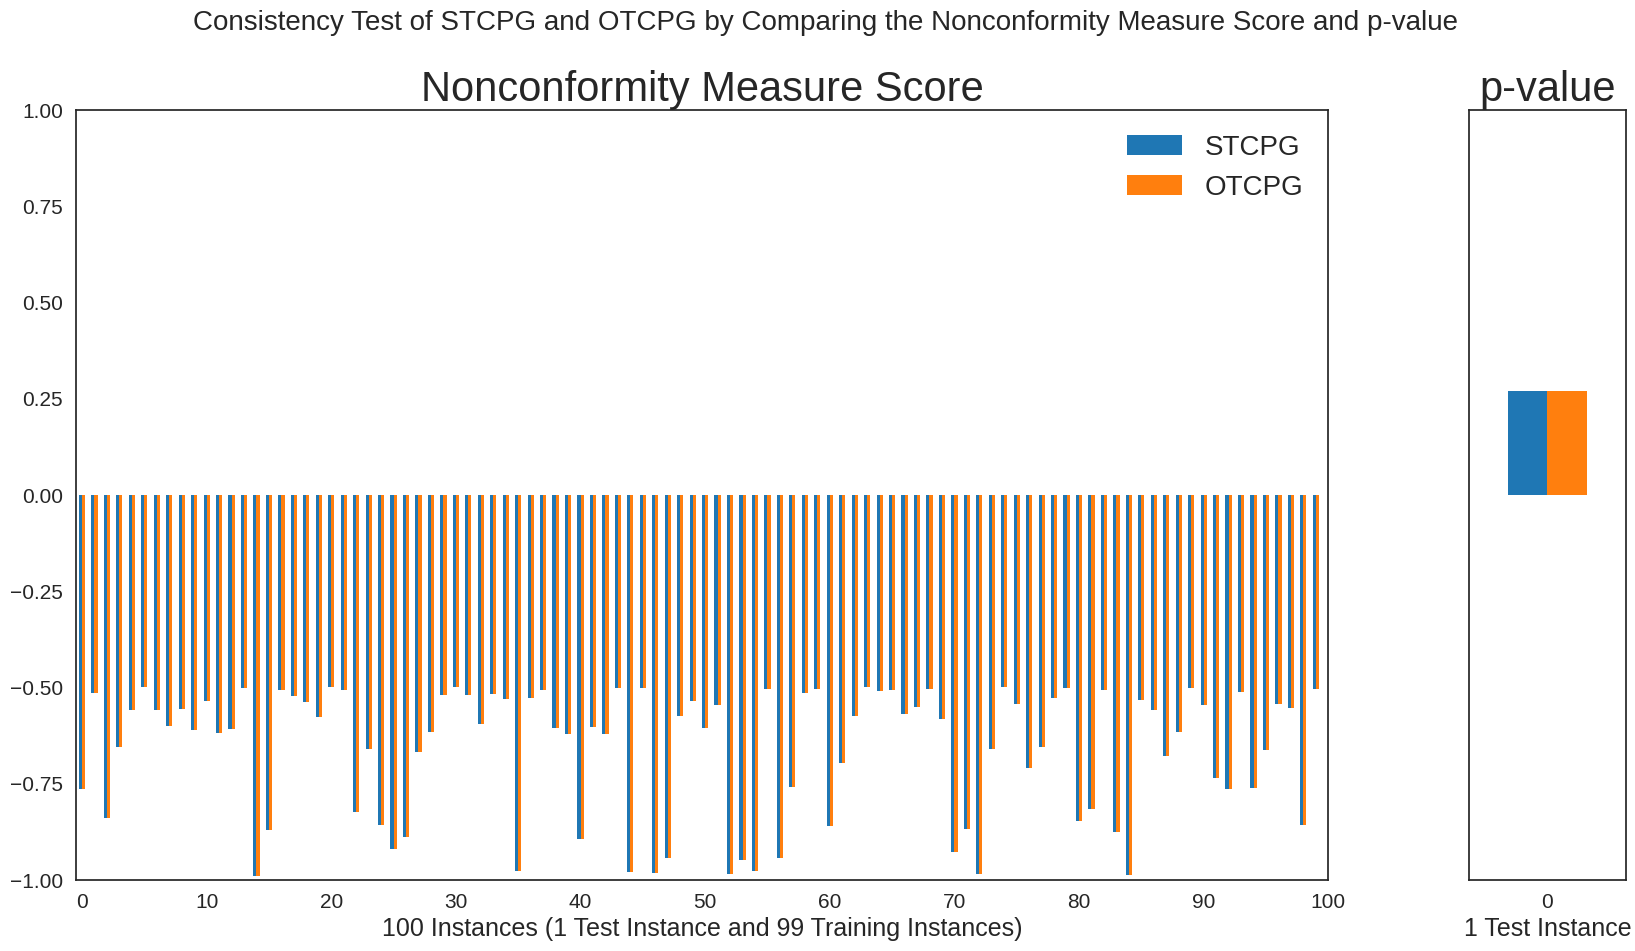

In [23]:
# Define a class to verify that STCPG is equivalent to OTCPG.
# Mainly by comparing nonconformity measure scores.
class STCPG_vs_OTCPG_Test(unittest.TestCase):
    
    def setUp(self):       
        X, Y = load_iris(return_X_y=True)
        # Only consider 2 classes (the first 100 instances, 50 for each class) for simplicity.
        X = X[0:100]
        Y = Y[0:100]  
        
        np.random.seed(0)
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(X, Y, test_size=1,random_state=0)
    
    @parameterized.expand([
        [STCPG(), OTCPG()]])
    
    def test_equivalent(self, ncm_a, ncm_b, rtol=1e-07):
        print(f"Testing: {ncm_a.__class__.__name__}, {ncm_b.__class__.__name__}")
        ncm_a.train(self.Xtrain, self.Ytrain)
        ncm_b.train(self.Xtrain, self.Ytrain)
        
        for x, y in zip(self.Xtest, self.Ytest):
            score_x_a, scores_a = ncm_a.compute_scores(x, y)
            score_x_b, scores_b = ncm_b.compute_scores(x, y)
            pvalue_a = (1 + sum(score_x_a >= scores_a)) / (1 + len(scores_a))
            pvalue_b = (1 + sum(score_x_b >= scores_b)) / (1 + len(scores_b))
            np.testing.assert_allclose(score_x_a, score_x_b, rtol=rtol)
            np.testing.assert_allclose(scores_a, scores_b, rtol=rtol)

            print("p-value:", pvalue_a, pvalue_b)

            # Collect 100 nonconformity measure socres.
            scores_a.insert(0,score_x_a)
            scores_b.insert(0,score_x_b)

            score = pd.DataFrame(
                {'Index':np.arange(1,101),
                 'STCPG': scores_a,
                 'OTCPG': scores_b
                 })
            pvalue = pd.DataFrame(
                {'Index':np.arange(1,2),
                 'STCPG': pvalue_a,
                 'OTCPG': pvalue_b
                 })
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10), gridspec_kw={'width_ratios': [8, 1]}, sharey = True)
            fig.suptitle('Consistency Test of STCPG and OTCPG by Comparing the Nonconformity Measure Score and p-value', fontsize=20)
            score.plot(x="Index", y=["STCPG", "OTCPG"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,101,10),title = 'Nonconformity Measure Score', ax=axes[0])
            axes[0].title.set_size(30)
            axes[0].legend(fontsize=20)
            axes[0].set_xlabel('100 Instances (1 Test Instance and 99 Training Instances)', fontsize=18)
            axes[0].tick_params(axis='both', labelsize=15)
            pvalue.plot(x="Index", y=["STCPG", "OTCPG"], rot=0, kind="bar",ylim = (-1,1),xticks = np.arange(0,1), title = 'p-value', ax=axes[1], legend=False)
            axes[1].title.set_size(30)
            axes[1].set_xlabel('1 Test Instance', fontsize=18)
            axes[1].tick_params(axis='both', labelsize=15)
suite = unittest.defaultTestLoader.loadTestsFromTestCase(STCPG_vs_OTCPG_Test)
_ = unittest.TextTestRunner().run(suite)

# Computational performance comparison


## Experiment

### Set Up Parameters 

In [24]:
EXPERIMENT_NAME = "training-size-comparison"
RESULTS_DIR = "results/"
# REPETITIONS = 5
REPETITIONS = 2
# TRAIN_SIZE = np.logspace(1, 5, 13, dtype='int').tolist()
TRAIN_SIZE = np.logspace(1, 3, 13, dtype='int').tolist()
# TRAIN_SIZE = np.logspace(1, 2, 3, dtype='int').tolist()
# MAX_TEST_SIZE = 100
MAX_TEST_SIZE = 10
N_CLASSES = 2
# N_DIMENSIONS = 30
N_DIMENSIONS = 5
TIMEOUT = 60*60*10

### STCPM vs OTCPM

In [25]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                  #  n_jobs=40,
                   n_jobs=-1,
                   automatic_seed=True,
                   # Parameters
                   ncm=["STCPM","OTCPM"],
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   is_mnb = True
                  )

Running: results/training-size-comparison/ncm=STCPM-train_size=31-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/1.json
Running: results/training-size-comparison/ncm=STCPM-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/0.json
Finished: results/training-size-comparison/ncm=STCPM-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/0.json
Running: results/training-size-comparison/ncm=STCPM-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/1.json
Finished: results/training-size-comparison/ncm=STCPM-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/1.json
Running: results/training-size-comparison/ncm=STCPM-train_size=14-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/0.json
Finished: results/training-size-comparison/ncm=STCPM-train_size=31-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=True/1.j

### STCPG vs OTCPG

In [26]:
eli = Eli(RESULTS_DIR)
eli.run_experiment(exp_name=EXPERIMENT_NAME,
                   func=evaluate_ncm,
                   repetitions=REPETITIONS,
                  #  n_jobs=40,
                   n_jobs = -1,
                   automatic_seed=True,
                   # Parameters
                   ncm=["STCPG","OTCPG"],
                   train_size=TRAIN_SIZE,
                   max_test_size=MAX_TEST_SIZE,
                   n_classes=N_CLASSES,
                   n_dimensions=N_DIMENSIONS,
                   timeout=TIMEOUT,
                   is_mnb = False
                  )

Running: results/training-size-comparison/ncm=STCPG-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/0.jsonRunning: results/training-size-comparison/ncm=STCPG-train_size=31-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/1.json

Failed: results/training-size-comparison/ncm=STCPG-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/0.json
float division by zero
Running: results/training-size-comparison/ncm=STCPG-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/1.json
Finished: results/training-size-comparison/ncm=STCPG-train_size=10-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/1.json
Running: results/training-size-comparison/ncm=STCPG-train_size=14-max_test_size=10-n_classes=2-n_dimensions=5-timeout=36000-is_mnb=False/0.json
Finished: results/training-size-comparison/ncm=STCPG-train_size=14-max_test_size=10-n_classes=2-n_dimensions=5-ti

## Results

In [27]:
# Load result data
eli = Eli(RESULTS_DIR)
results = eli.fetch_results("training-size-comparison")

# Define a function to return the average prediction time for each 
# observation and store it in 'avg_time'.
avgerage_time = lambda vec: np.concatenate(([vec[0]], pd.Series(vec).diff()[1:])).mean()
results["avg_time"] = results.prediction_time.apply(avgerage_time)

print(f"{len(results)} observations")
results.head()

102 observations


,name,training_time,prediction_time,reached_timeout,ncm,train_size,max_test_size,n_classes,n_dimensions,timeout,is_mnb,repetition,git-commit,started,finished,avg_time
0,ncm=OTCPG-train_size=1000-max_test_size=10-n_c...,0.030285,"[0.7198239809999905, 1.4588955389999683, 2.167...",False,OTCPG,1000,10,2,5,36000,False,0,no-git-repo,2023-05-20T11:59:04.583466+00:00,2023-05-20T11:59:13.163173+00:00,0.851961
1,ncm=OTCPG-train_size=1000-max_test_size=10-n_c...,0.031352,"[0.7361701029999494, 1.4565670430001774, 2.187...",False,OTCPG,1000,10,2,5,36000,False,1,no-git-repo,2023-05-20T11:59:13.189134+00:00,2023-05-20T11:59:20.487116+00:00,0.723770
2,ncm=OTCPG-train_size=146-max_test_size=10-n_cl...,0.026858,"[0.10366252299991174, 0.23148602299988852, 0.3...",False,OTCPG,146,10,2,5,36000,False,0,no-git-repo,2023-05-20T11:58:35.118724+00:00,2023-05-20T11:58:36.253370+00:00,0.108209
3,ncm=OTCPG-train_size=146-max_test_size=10-n_cl...,0.030083,"[0.10564257500027452, 0.20922907500016663, 0.3...",False,OTCPG,146,10,2,5,36000,False,1,no-git-repo,2023-05-20T11:58:36.280556+00:00,2023-05-20T11:58:37.409386+00:00,0.107360
4,ncm=STCPM-train_size=464-max_test_size=10-n_cl...,0.000144,"[24.638394526999946, 49.23901071099999, 72.779...",False,STCPM,464,10,2,5,36000,True,0,no-git-repo,2023-05-20T11:18:00.318883+00:00,2023-05-20T11:22:05.692260+00:00,24.533307


In [28]:
MAX_TRAIN_SIZE = max(TRAIN_SIZE)
print("STCPM (train: {} test: {}): \n\t Average Training Time: {} seconds \n\t Average Prediction Time: {} seconds \n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="STCPM") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="STCPM") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("OTCPM (train: {} test: {}): \n\t Average Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPM") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("STCPG (train: {} test: {}): \n\t Average Training Time: {} seconds \n\t Average Prediction Time: {} seconds\n".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="STCPG") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="STCPG") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

print("OTCPG (train: {} test: {}): \n\t Average Training Time: {} seconds \n\t Average Prediction Time: {} seconds".format(
    MAX_TRAIN_SIZE,
    MAX_TEST_SIZE,
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE)].training_time.mean(),
    results[(results.ncm=="OTCPG") & (results.train_size==MAX_TRAIN_SIZE)].avg_time.mean()
))

STCPM (train: 1000 test: 10): 
	 Average Training Time: 0.00025168249999296677 seconds 
	 Average Prediction Time: 39.98335090500001 seconds 

OTCPM (train: 1000 test: 10): 
	 Average Training Time: 0.04791184950011029 seconds 
	 Average Prediction Time: 0.7096692343499966 seconds

STCPG (train: 1000 test: 10): 
	 Average Training Time: 1.4132000160316238e-05 seconds 
	 Average Prediction Time: 41.75243143944999 seconds

OTCPG (train: 1000 test: 10): 
	 Average Training Time: 0.03081853200023943 seconds 
	 Average Prediction Time: 0.7878657015999806 seconds


## Plots

For Standard TCP using MultinomialNB or GaussianNB, the training time just refers to the process of storing the training data as an element of the NCM object, while optimized ones need to train the classifiers for the first time. So the training time is not comparable, and we only compare the average prediction time.

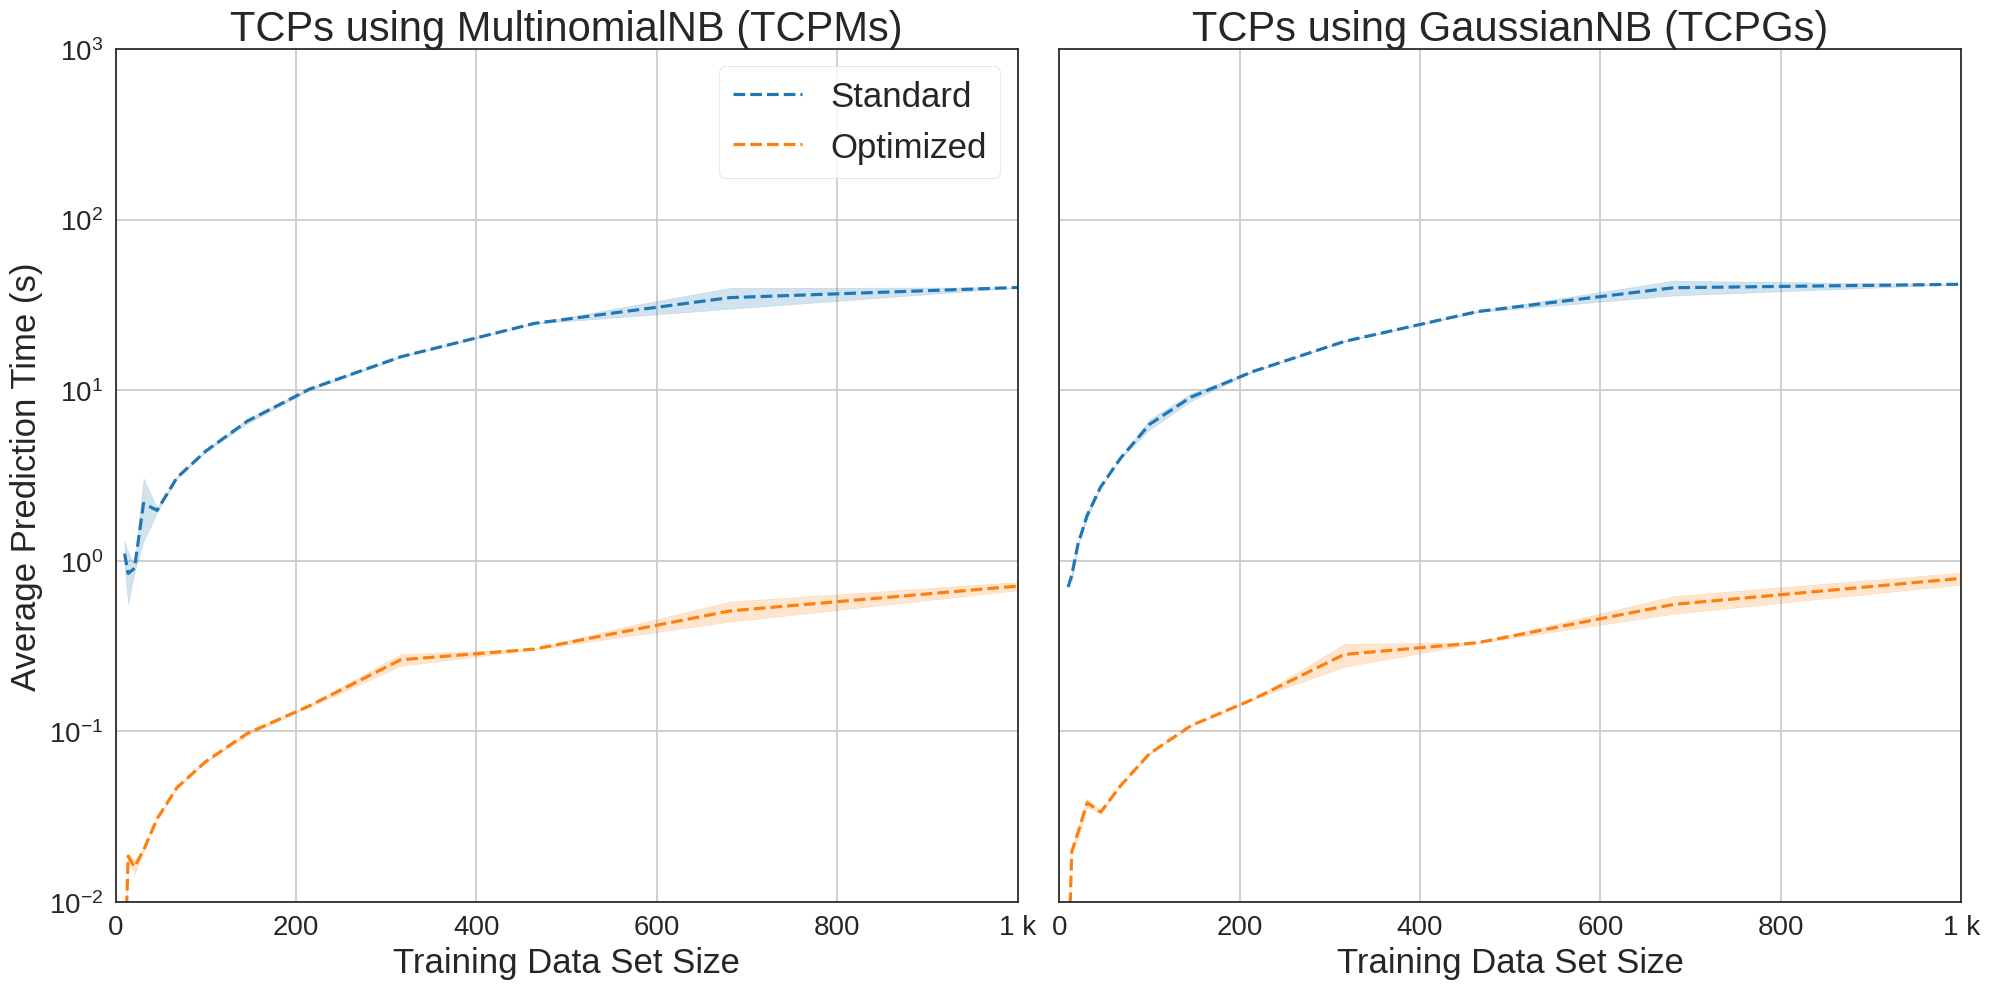

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 10))
colors = sns.color_palette()
NCMS = ["TCPM","TCPG"]

for i, (ax, ncm) in enumerate(zip(axes.flat, NCMS)):
    plot_data = results[((results.ncm == "S"+ncm) | (results.ncm == "O"+ncm))]

    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm=="S"+ncm],
                 ax=ax, legend=None, label="Standard",
                 color=colors[0])
    sns.lineplot(x="train_size", y="avg_time",
                 data=plot_data[plot_data.ncm=="O"+ncm],
                 ax=ax, legend=None, label="Optimized",
                 color=colors[1])
    
    ax.lines[0].set_linestyle("--")
    ax.lines[1].set_linestyle("--")

    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.tick_params(axis='both',labelsize=20)
    ax.grid()
    ax.set_xlim([0, 10**3])
    ax.set_ylim([10**-2, 10**3])
    ax.set_title("TCPs using MultinomialNB (TCPMs)" if NCMS[i][3]=="M" else "TCPs using GaussianNB (TCPGs)", fontsize=30)
    ax.set_xlabel("Training Data Set Size", fontsize=25)
    ax.set_ylabel("Average Prediction Time (s)",fontsize=25)
    if i == 0:
        ax.set_ylabel("Average Prediction Time (s)")
        ax.legend(title="", loc="best", frameon=True, fontsize=25)
    else:
        ax.set_ylabel(None)
        plt.setp(ax.get_yticklabels(), visible=False)

# fig.suptitle('Computational Performance Comparison between Standard and Optimized TCP using Multinomial or GaussianNB', fontsize=30)
plt.tight_layout()